### Réduction des dimenssions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%%time 
import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


def compute_coherence_values(dictionary, corpus, texts, limit, mallet=False, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Args:
  
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
    
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        
        if mallet == True:
            model = gensim.models.wrappers.LdaMallet(mallet_path = mallet_path, 
                                                     corpus=corpus, num_topics=num_topics, 
                                                     id2word=id2word, 
                                                     prefix='temp_file_',
                                                     workers=3)
        
        else:
            model = LdaMulticore(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics, 
                                random_state=42,
                                chunksize=100,
                                passes=10,
                                workers=3)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=corpus_tfidf, texts=texts, start=2, limit=51, step=1)

CPU times: user 698 ms, sys: 317 ms, total: 1.01 s
Wall time: 3.7 s


In [4]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus_tfidf, texts=html_cleaned_texts)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # Show
# df_dominant_topic.head(10)

### Avec bigrammes lematizés

In [ ]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

data = filtered_data['tokenized_post'].values.tolist()

bigram = gensim.models.Phrases(data, min_count=1000, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

data_bigrams = [bigram_mod[doc] for doc in data]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

bigrams_data = make_bigrams(data)
lemmatized_data = lemmatization(bigrams_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(lemmatized_data)
corpus = [id2word.doc2bow(text) for text in texts] 
bow_corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=bow_corpus, texts=lemmatized_data, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
%%time
from pprint import pprint
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
%%time
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=html_cleaned_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])

In [ ]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

In [ ]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
    print("Publication la plus significative du topic:")
    print("\n")
    print(f"{row['Text']}")
    print("\n")
    print("=" * 50)

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data.html')
display(HTML('lda_imported_data.html'))

## Avec données importées

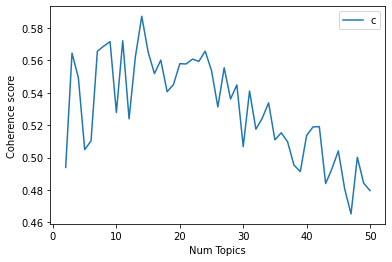

Num Topics = 2  has Coherence Value of 0.4939
Num Topics = 3  has Coherence Value of 0.5645
Num Topics = 4  has Coherence Value of 0.5494
Num Topics = 5  has Coherence Value of 0.5049
Num Topics = 6  has Coherence Value of 0.5103
Num Topics = 7  has Coherence Value of 0.5657
Num Topics = 8  has Coherence Value of 0.5688
Num Topics = 9  has Coherence Value of 0.5716
Num Topics = 10  has Coherence Value of 0.5278
Num Topics = 11  has Coherence Value of 0.5722
Num Topics = 12  has Coherence Value of 0.5239
Num Topics = 13  has Coherence Value of 0.5624
Num Topics = 14  has Coherence Value of 0.5873
Num Topics = 15  has Coherence Value of 0.5653
Num Topics = 16  has Coherence Value of 0.5519
Num Topics = 17  has Coherence Value of 0.5602
Num Topics = 18  has Coherence Value of 0.5407
Num Topics = 19  has Coherence Value of 0.5451
Num Topics = 20  has Coherence Value of 0.558
Num Topics = 21  has Coherence Value of 0.5578
Num Topics = 22  has Coherence Value of 0.5609
Num Topics = 23  has C

In [13]:
%%time
data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts) 
bow_corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=bow_corpus, texts=texts, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [14]:
%%time
from pprint import pprint
optimal_model = model_list[12]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.323*"java" + 0.047*"apache" + 0.029*"execution" + 0.023*"lang" + '
  '0.020*"junit" + 0.017*"kafka" + 0.012*"execute" + 0.012*"method" + '
  '0.011*"base" + 0.010*"annotation"'),
 (1,
  '0.037*"value" + 0.034*"model" + 0.028*"list" + 0.022*"code" + '
  '0.022*"column" + 0.021*"type" + 0.020*"name" + 0.020*"return" + '
  '0.019*"class" + 0.018*"example"'),
 (2,
  '0.091*"view" + 0.072*"java" + 0.042*"activity" + 0.037*"intent" + '
  '0.030*"action" + 0.028*"void" + 0.027*"android" + 0.027*"handler" + '
  '0.027*"notification" + 0.022*"class"'),
 (3,
  '0.098*"flutter" + 0.040*"package" + 0.039*"dart" + 0.035*"child" + '
  '0.028*"context" + 0.027*"widget" + 0.020*"return" + 0.011*"scroll" + '
  '0.011*"title" + 0.010*"send"'),
 (4,
  '0.029*"http" + 0.027*"request" + 0.026*"client" + 0.025*"service" + '
  '0.019*"name" + 0.019*"server" + 0.019*"date" + 0.015*"user" + '
  '0.015*"access" + 0.014*"database"'),
 (5,
  '0.036*"execute" + 0.035*"provider" + 0.032*"gradle" + 0.029*"

In [18]:
%%time
original_posts = data['Post'].to_list()
original_cleaned_keywords = data['splitted_tags']
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=original_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

CPU times: user 4min 52s, sys: 40.4 s, total: 5min 32s
Wall time: 5min 34s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,11.0,0.3538,"error, version, project, system, code, file, s...",Can (a== 1 && a ==2 && a==3) ever evaluate to ...,"[javascript, ecmascript]"
1,1.0,11.0,0.6205,"error, version, project, system, code, file, s...",Git is not working after macOS Update (xcrun: ...,"[xcode, macos, command, line, terminal]"
2,2.0,11.0,0.6864,"error, version, project, system, code, file, s...",Why is 2 * (i * i) faster than 2 * i * i in Ja...,"[java, performance, benchmarking, bytecode]"
3,3.0,11.0,0.9527,"error, version, project, system, code, file, s...",Xcode 10 Error: Multiple commands produce <blo...,"[info, plist, xcode]"
4,4.0,1.0,0.4224,"value, model, list, code, column, type, name, ...","Why does array[idx++]+=""a"" increase idx once i...","[java, java, javac, java, java]"
5,5.0,11.0,0.5131,"error, version, project, system, code, file, s...",Difference between npx and npm? <p>I have just...,[javascript]
6,6.0,11.0,0.4462,"error, version, project, system, code, file, s...",Cannot inline bytecode built with JVM target 1...,"[android, intellij, idea, kotlin, corda]"
7,7.0,8.0,0.6842,"test, json, error, function, const, response, ...","Could not find module ""@angular-devkit/build-a...","[angular, angular, angular, angular]"
8,8.0,7.0,0.4530,"file, python, module, line, import, path, erro...","How to fix ""ReferenceError: primordials is not...","[node, sas, gulp, gulp, sas]"
9,9.0,8.0,0.3982,"test, json, error, function, const, response, ...",Why is the result of ('b'+'a'+ + 'a' + 'a').to...,"[javascript, type, conversion]"


In [19]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])
print("\n")
print("Mots clés originaux")
display(df_dominant_topic.loc[0, 'Original_keywords'])

Publication du premier document



'Can (a== 1 && a ==2 && a==3) ever evaluate to true? <blockquote>\n  <p><strong>Moderator note:</strong> Please resist the urge to edit the code or remove this notice. The pattern of whitespace may be part of the question and therefore should not be tampered with unnecessarily. If you are in the "whitespace is insignificant" camp, you should be able to accept the code as is.</p>\n</blockquote>\n\n<p>Is it ever possible that <code>(a== 1 &amp;&amp; a ==2 &amp;&amp; a==3)</code> could evaluate to <code>true</code> in JavaScript?</p>\n\n<p>This is an interview question asked by a major tech company. It happened two weeks back, but I\'m still trying to find the answer. I know we never write such code in our day-to-day job, but I\'m curious.</p>\n'



Numéro du topic: 11.0


Mots clés associés



'error, version, project, system, code, file, studio, build, command, debug'



Mots clés originaux


['javascript', 'ecmascript']

In [20]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9775,"java, apache, execution, lang, junit, kafka, e...",Error: java.util.concurrent.ExecutionException...
1,1.0,0.9762,"value, model, list, code, column, type, name, ...",Why use std::make_unique in C++17? <p>As far a...
2,2.0,0.9558,"view, java, activity, intent, action, void, an...",Handler(Handler.Callback) is deprecated <p>Han...
3,3.0,0.9850,"flutter, package, dart, child, context, widget...",Another exception was thrown: No TabController...
4,4.0,0.9802,"http, request, client, service, name, server, ...",CORS policy don't want to work with SignalR an...
5,5.0,0.7253,"execute, provider, gradle, daemon, server, plo...",matplotlib/seaborn: first and last row cut in ...
6,6.0,0.9957,"google, implementation, firebase, support, and...",Error : Program type already present: android....
7,7.0,0.9909,"file, python, module, line, import, path, erro...",How to fix -- bash: /usr/bin/python: Too many ...
8,8.0,0.9843,"test, json, error, function, const, response, ...","JS - fetch API, GET method return ""ƒ json() { ..."
9,9.0,0.9810,"android, layout, parent, navigation, material,...",Using FragmentContainerView with Navigation co...


In [21]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
    print("Publication la plus significative du topic:")
    print("\n")
    print(f"{row['Text']}")
    print("\n")
    print("=" * 50)

Numéro du topic: 0.0


Mots clés associes au topic:

java, apache, execution, lang, junit, kafka, execute, method, base, annotation


Publication la plus significative du topic:


Error: java.util.concurrent.ExecutionException: com.android.builder.internal.aapt.v2.Aapt2Exception: AAPT2 error when compiling on Windows 10 <p>somehow my android project that I ran and compiled completely normal on Kali Linux,
can't be compiled on windows 10. I already twice totally removed whole Android studio and gradle build tools and it's cached, invalidating project caches, and so on.
Not only that one project won't compile, but any.
I have all SDK tools freshly installed and updated.</p>

<p>Here is my stack trace from java compiler:</p>

<pre><code>FAILURE: Build failed with an exception.
</code></pre>

<ul>
<li><p>What went wrong:
Execution failed for task ':app:mergeDebugResources'.</p>

<blockquote>
  <p>Error: java.util.concurrent.ExecutionException: com.android.builder.internal.aapt.v2.Aapt2Exce

In [22]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"java, apache, execution, lang, junit, kafka, e...",618,0.0135
1.0,1.0,"value, model, list, code, column, type, name, ...",7394,0.1611
2.0,2.0,"view, java, activity, intent, action, void, an...",448,0.0098
3.0,3.0,"flutter, package, dart, child, context, widget...",1166,0.0254
4.0,4.0,"http, request, client, service, name, server, ...",7015,0.1528
5.0,5.0,"execute, provider, gradle, daemon, server, plo...",165,0.0036
6.0,6.0,"google, implementation, firebase, support, and...",1116,0.0243
7.0,7.0,"file, python, module, line, import, path, erro...",5143,0.1120
8.0,8.0,"test, json, error, function, const, response, ...",3660,0.0797
9.0,9.0,"android, layout, parent, navigation, material,...",480,0.0105


In [23]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data.html')
display(HTML('lda_imported_data.html'))

CPU times: user 12 s, sys: 1.37 s, total: 13.4 s
Wall time: 25.5 s


### Avec tf-idf

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


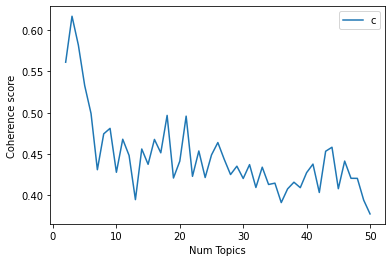

Num Topics = 2  has Coherence Value of 0.5611
Num Topics = 3  has Coherence Value of 0.6167
Num Topics = 4  has Coherence Value of 0.5819
Num Topics = 5  has Coherence Value of 0.5329
Num Topics = 6  has Coherence Value of 0.4991
Num Topics = 7  has Coherence Value of 0.4311
Num Topics = 8  has Coherence Value of 0.4745
Num Topics = 9  has Coherence Value of 0.4812
Num Topics = 10  has Coherence Value of 0.428
Num Topics = 11  has Coherence Value of 0.468
Num Topics = 12  has Coherence Value of 0.4484
Num Topics = 13  has Coherence Value of 0.395
Num Topics = 14  has Coherence Value of 0.4562
Num Topics = 15  has Coherence Value of 0.4377
Num Topics = 16  has Coherence Value of 0.4678
Num Topics = 17  has Coherence Value of 0.4516
Num Topics = 18  has Coherence Value of 0.4968
Num Topics = 19  has Coherence Value of 0.4211
Num Topics = 20  has Coherence Value of 0.4415
Num Topics = 21  has Coherence Value of 0.4959
Num Topics = 22  has Coherence Value of 0.4231
Num Topics = 23  has Coh

In [69]:
%%time

from gensim.models import TfidfModel
data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [70]:
%%time
from pprint import pprint
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.005*"file" + 0.005*"error" + 0.005*"version" + 0.004*"python" + '
  '0.004*"java" + 0.004*"docker" + 0.004*"project" + 0.004*"json" + '
  '0.003*"http" + 0.003*"module"'),
 (1,
  '0.003*"conda" + 0.001*"cypress" + 0.001*"wkwebview" + 0.001*"escape" + '
  '0.001*"defaultbuildoperationexecutor" + 0.001*"pyqt" + 0.000*"heatmap" + '
  '0.000*"forge" + 0.000*"tokenizer" + 0.000*"mediarecorder"'),
 (2,
  '0.001*"unity" + 0.001*"puppeteer" + 0.001*"pickle" + 0.000*"injector" + '
  '0.000*"zygoteinit" + 0.000*"leaflet" + 0.000*"pyarrow" + 0.000*"mymodule" + '
  '0.000*"remotemessage" + 0.000*"slack"'),
 (3,
  '0.005*"value" + 0.005*"class" + 0.005*"component" + 0.004*"button" + '
  '0.004*"column" + 0.004*"list" + 0.004*"color" + 0.003*"state" + '
  '0.003*"import" + 0.003*"view"')]
CPU times: user 19 ms, sys: 18.9 ms, total: 37.8 ms
Wall time: 37.3 ms


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
%%time
original_posts = data['Post'].to_list()
original_cleaned_keywords = data['splitted_tags']
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tfidf_corpus, texts=original_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 3min 1s, sys: 4.86 s, total: 3min 5s
Wall time: 3min 6s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,3.0,0.5464,"value, class, component, button, column, list,...",Can (a== 1 && a ==2 && a==3) ever evaluate to ...,"[javascript, ecmascript]"
1,1.0,0.0,0.7962,"file, error, version, python, java, docker, pr...",Git is not working after macOS Update (xcrun: ...,"[xcode, macos, command, line, terminal]"
2,2.0,0.0,0.6617,"file, error, version, python, java, docker, pr...",Why is 2 * (i * i) faster than 2 * i * i in Ja...,"[java, performance, benchmarking, bytecode]"
3,3.0,0.0,0.8057,"file, error, version, python, java, docker, pr...",Xcode 10 Error: Multiple commands produce <blo...,"[info, plist, xcode]"
4,4.0,0.0,0.5240,"file, error, version, python, java, docker, pr...","Why does array[idx++]+=""a"" increase idx once i...","[java, java, javac, java, java]"
5,5.0,0.0,0.8019,"file, error, version, python, java, docker, pr...",Difference between npx and npm? <p>I have just...,[javascript]
6,6.0,0.0,0.7393,"file, error, version, python, java, docker, pr...",Cannot inline bytecode built with JVM target 1...,"[android, intellij, idea, kotlin, corda]"
7,7.0,0.0,0.7941,"file, error, version, python, java, docker, pr...","Could not find module ""@angular-devkit/build-a...","[angular, angular, angular, angular]"
8,8.0,0.0,0.8287,"file, error, version, python, java, docker, pr...","How to fix ""ReferenceError: primordials is not...","[node, sas, gulp, gulp, sas]"
9,9.0,3.0,0.7774,"value, class, component, button, column, list,...",Why is the result of ('b'+'a'+ + 'a' + 'a').to...,"[javascript, type, conversion]"


In [72]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])
print("\n")
print("Mots clés originaux")
display(df_dominant_topic.loc[0, 'Original_keywords'])

Publication du premier document



/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Can (a== 1 && a ==2 && a==3) ever evaluate to true? <blockquote>\n  <p><strong>Moderator note:</strong> Please resist the urge to edit the code or remove this notice. The pattern of whitespace may be part of the question and therefore should not be tampered with unnecessarily. If you are in the "whitespace is insignificant" camp, you should be able to accept the code as is.</p>\n</blockquote>\n\n<p>Is it ever possible that <code>(a== 1 &amp;&amp; a ==2 &amp;&amp; a==3)</code> could evaluate to <code>true</code> in JavaScript?</p>\n\n<p>This is an interview question asked by a major tech company. It happened two weeks back, but I\'m still trying to find the answer. I know we never write such code in our day-to-day job, but I\'m curious.</p>\n'



Numéro du topic: 3.0


Mots clés associés



'value, class, component, button, column, list, color, state, import, view'



Mots clés originaux


['javascript', 'ecmascript']

In [73]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9243,"file, error, version, python, java, docker, pr...",Webapi 2.0 how to implement refresh JWT token ...
1,1.0,0.9468,"conda, cypress, wkwebview, escape, defaultbuil...",how to detect the MIME type of data URL <p>I'm...
2,2.0,0.8311,"unity, puppeteer, pickle, injector, zygoteinit...",Manually create JWK from (RSA) PublicKey <p>I ...
3,3.0,0.9187,"value, class, component, button, column, list,...",Flutter: keyboard disappears immediately when ...


Numéro du topic: 0.0


Mots clés associes au topic:

file, error, version, python, java, docker, project, json, http, module


Publication la plus significative du topic:


Webapi 2.0 how to implement refresh JWT token when access token expired <p>I am quite new in web API implementation, I have created a web API service to use it with <code>ASP.net web form</code> applications as well as some stand alone applications(C# Console/Windows application) using <code>HttpClient</code> object.</p>

<p>I have implemented a basic JWT access token authentication with expiration time limit in web api, this authentication technique is working fine until token not expired, when token get expired web api does not accept request as token has expired! which is fine as per authentication implementation, but I want to implement refresh token logic in web api so token can renew/refersh and client should be able to use the web api resource. </p>

<p>I googled a lot but unable to find the proper implementa
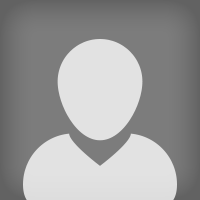

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
    print("Publication la plus significative du topic:")
    print("\n")
    print(f"{row['Text']}")
    print("\n")
    print("=" * 50)

In [75]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"file, error, version, python, java, docker, pr...",27439,0.5978
1.0,1.0,"conda, cypress, wkwebview, escape, defaultbuil...",244,0.0053
2.0,2.0,"unity, puppeteer, pickle, injector, zygoteinit...",252,0.0055
3.0,3.0,"value, class, component, button, column, list,...",17967,0.3914


In [76]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data_tfidf.html')
display(HTML('lda_imported_data_tfidf.html'))

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 8.61 s, sys: 475 ms, total: 9.09 s
Wall time: 13.3 s


### Avec un dictionary ne contenant que les mots ayant plus de 1000 occurences

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


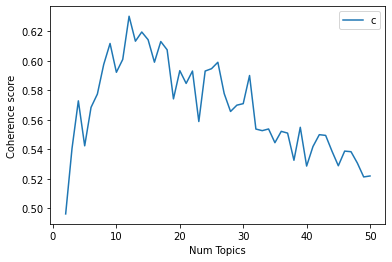

Num Topics = 2  has Coherence Value of 0.4962
Num Topics = 3  has Coherence Value of 0.5405
Num Topics = 4  has Coherence Value of 0.5729
Num Topics = 5  has Coherence Value of 0.5424
Num Topics = 6  has Coherence Value of 0.5684
Num Topics = 7  has Coherence Value of 0.5775
Num Topics = 8  has Coherence Value of 0.5975
Num Topics = 9  has Coherence Value of 0.6118
Num Topics = 10  has Coherence Value of 0.5922
Num Topics = 11  has Coherence Value of 0.6009
Num Topics = 12  has Coherence Value of 0.6302
Num Topics = 13  has Coherence Value of 0.6133
Num Topics = 14  has Coherence Value of 0.6195
Num Topics = 15  has Coherence Value of 0.6143
Num Topics = 16  has Coherence Value of 0.5991
Num Topics = 17  has Coherence Value of 0.6131
Num Topics = 18  has Coherence Value of 0.6075
Num Topics = 19  has Coherence Value of 0.5742
Num Topics = 20  has Coherence Value of 0.5933
Num Topics = 21  has Coherence Value of 0.5847
Num Topics = 22  has Coherence Value of 0.5931
Num Topics = 23  has 

In [77]:
%%time
data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=500)
bow_corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(mallet=False, dictionary=id2word, corpus=bow_corpus, texts=texts, start=2, limit=51, step=1)

limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [78]:
%%time
from pprint import pprint
optimal_model = model_list[12]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.155*"android" + 0.089*"google" + 0.061*"layout" + 0.053*"implementation" '
  '+ 0.052*"firebase" + 0.048*"support" + 0.045*"parent" + 0.042*"permission" '
  '+ 0.034*"storage" + 0.034*"activity"'),
 (1,
  '0.485*"java" + 0.093*"apache" + 0.041*"lang" + 0.041*"execution" + '
  '0.029*"method" + 0.028*"base" + 0.026*"execute" + 0.021*"invoke" + '
  '0.019*"source" + 0.014*"server"'),
 (2,
  '0.103*"name" + 0.095*"value" + 0.051*"type" + 0.045*"form" + 0.043*"list" + '
  '0.038*"class" + 0.032*"number" + 0.031*"input" + 0.030*"column" + '
  '0.027*"group"'),
 (3,
  '0.109*"spring" + 0.102*"core" + 0.093*"springframework" + 0.093*"release" + '
  '0.066*"boot" + 0.054*"info" + 0.046*"dependency" + 0.039*"version" + '
  '0.028*"product" + 0.026*"class"'),
 (4,
  '0.179*"file" + 0.104*"python" + 0.091*"line" + 0.068*"image" + '
  '0.053*"import" + 0.048*"site" + 0.032*"path" + 0.031*"self" + '
  '0.030*"module" + 0.022*"error"'),
 (5,
  '0.157*"import" + 0.088*"const" + 0.075*"compo

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
%%time
original_posts = data['Post'].to_list()
original_cleaned_keywords = data['splitted_tags']
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=original_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2min 14s, sys: 1.46 s, total: 2min 15s
Wall time: 2min 19s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,12.0,0.8376,"example, code, access, problem, work, question...",Can (a== 1 && a ==2 && a==3) ever evaluate to ...,"[javascript, ecmascript]"
1,1.0,13.0,0.6483,"version, error, package, project, flutter, ins...",Git is not working after macOS Update (xcrun: ...,"[xcode, macos, command, line, terminal]"
2,2.0,9.0,0.5629,"function, return, error, message, test, class,...",Why is 2 * (i * i) faster than 2 * i * i in Ja...,"[java, performance, benchmarking, bytecode]"
3,3.0,13.0,0.8555,"version, error, package, project, flutter, ins...",Xcode 10 Error: Multiple commands produce <blo...,"[info, plist, xcode]"
4,4.0,9.0,0.4665,"function, return, error, message, test, class,...","Why does array[idx++]+=""a"" increase idx once i...","[java, java, javac, java, java]"
5,5.0,13.0,0.3526,"version, error, package, project, flutter, ins...",Difference between npx and npm? <p>I have just...,[javascript]
6,6.0,13.0,0.7581,"version, error, package, project, flutter, ins...",Cannot inline bytecode built with JVM target 1...,"[android, intellij, idea, kotlin, corda]"
7,7.0,10.0,0.6086,"script, node, module, index, page, html, path,...","Could not find module ""@angular-devkit/build-a...","[angular, angular, angular, angular]"
8,8.0,13.0,0.2669,"version, error, package, project, flutter, ins...","How to fix ""ReferenceError: primordials is not...","[node, sas, gulp, gulp, sas]"
9,9.0,10.0,0.4036,"script, node, module, index, page, html, path,...",Why is the result of ('b'+'a'+ + 'a' + 'a').to...,"[javascript, type, conversion]"


In [80]:
print("Publication du premier document\n")
display(df_dominant_topic.loc[0,'Text'])
print("\n")
print(f"Numéro du topic: {df_dominant_topic.loc[0,'Dominant_Topic']}")
print("\n")
print("Mots clés associés\n")
display(df_dominant_topic.loc[0,'Keywords'])
print("\n")
print("Mots clés originaux")
display(df_dominant_topic.loc[0, 'Original_keywords'])

Publication du premier document



/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Can (a== 1 && a ==2 && a==3) ever evaluate to true? <blockquote>\n  <p><strong>Moderator note:</strong> Please resist the urge to edit the code or remove this notice. The pattern of whitespace may be part of the question and therefore should not be tampered with unnecessarily. If you are in the "whitespace is insignificant" camp, you should be able to accept the code as is.</p>\n</blockquote>\n\n<p>Is it ever possible that <code>(a== 1 &amp;&amp; a ==2 &amp;&amp; a==3)</code> could evaluate to <code>true</code> in JavaScript?</p>\n\n<p>This is an interview question asked by a major tech company. It happened two weeks back, but I\'m still trying to find the answer. I know we never write such code in our day-to-day job, but I\'m curious.</p>\n'



Numéro du topic: 12.0


Mots clés associés



'example, code, access, problem, work, question, time, something, store, solution'



Mots clés originaux


['javascript', 'ecmascript']

In [81]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9423,"android, google, layout, implementation, fireb...",updating the version of com.google.android.gms...
1,1.0,0.9717,"java, apache, lang, execution, method, base, e...",Gradle crashes in app:transformDexWithInstantR...
2,2.0,0.9752,"name, value, type, form, list, class, number, ...",How to disable a checkbox based on conditions ...
3,3.0,0.9511,"spring, core, springframework, release, boot, ...",SpringBoot 2 Actuator with Spring Security <p>...
4,4.0,0.9919,"file, python, line, image, import, site, path,...",AttributeError: module 'tensorflow.python.kera...
5,5.0,0.9768,"import, const, component, state, react, event,...",Using useState hook in useEffect on history.li...
6,6.0,0.9668,"date, model, size, time, output, print, test, ...",Error when checking input: expected dense_inpu...
7,7.0,0.9156,"json, http, request, response, client, post, s...",Create a json payload in Go Lang POST request?...
8,8.0,0.9668,"docker, password, server, name, service, datab...",How to configure mariadb docker-compose file t...
9,9.0,0.9643,"function, return, error, message, test, class,...","C wait for signal with loop <p>In C Linux, is ..."


In [82]:
for index, row in sent_topics_sorteddf.iterrows():
    print(f"Numéro du topic: {row['Topic_Num']}")
    print("\n")
    print("Mots clés associes au topic:\n")
    print(f"{row['Keywords']}")
    print("\n")
    print("Publication la plus significative du topic:")
    print("\n")
    print(f"{row['Text']}")
    print("\n")
    print("=" * 50)

Numéro du topic: 0.0


Mots clés associes au topic:

android, google, layout, implementation, firebase, support, parent, permission, storage, activity


Publication la plus significative du topic:


updating the version of com.google.android.gms to 15.0.2 <p>I have updated my Firebase SDK version. But theres error of updating the version of com.google.android.gms to 15.0.2. I tried to make firebase and google services of same version but it wont work.</p>

<p>Dependencies</p>

<pre><code>dependencies {
implementation 'com.google.firebase:firebase-messaging:15.0.2'
implementation 'com.android.support:design:26.1.0'
implementation fileTree(include: ['*.jar'], dir: 'libs')
implementation 'com.google.firebase:firebase-ads:15.0.1'
androidTestImplementation('com.android.support.test.espresso:espresso-core:2.2.2', {
    exclude group: 'com.android.support', module: 'support-annotations'
})
implementation 'com.android.support:appcompat-v7:26.1.0'
implementation 'com.android.support.constraint:

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"android, google, layout, implementation, fireb...",1308,0.0285
1.0,1.0,"java, apache, lang, execution, method, base, e...",782,0.0170
2.0,2.0,"name, value, type, form, list, class, number, ...",5862,0.1277
3.0,3.0,"spring, core, springframework, release, boot, ...",1130,0.0246
4.0,4.0,"file, python, line, image, import, site, path,...",3519,0.0767
5.0,5.0,"import, const, component, state, react, event,...",2903,0.0632
6.0,6.0,"date, model, size, time, output, print, test, ...",2429,0.0529
7.0,7.0,"json, http, request, response, client, post, s...",2188,0.0477
8.0,8.0,"docker, password, server, name, service, datab...",3477,0.0757
9.0,9.0,"function, return, error, message, test, class,...",4700,0.1024


In [84]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, bow_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_imported_data_higher_freq.html')
display(HTML('lda_imported_data_higher_freq.html'))

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 7.67 s, sys: 293 ms, total: 7.96 s
Wall time: 11.1 s
